### Some useful references:
1. **[Training]**: https://github.com/LIHANG-HONG/birdclef2023-2nd-place-solution
2. **[Inference]**: https://www.kaggle.com/code/kadircandrisolu/efficientnet-b0-pytorch-inference-birdclef-25

This model backbone is seresnext26t_32x4d

## SED model

In [1]:
MODE = "inference"  
KAGGLE_NOTEBOOK = False

In [2]:
import os
import gc
import warnings
import logging
import time
import math
import cv2
from pathlib import Path
import joblib

import numpy as np
import pandas as pd
import librosa
import soundfile as sf
from soundfile import SoundFile 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
import timm
from tqdm.auto import tqdm
from glob import glob
import torchaudio
import random
import itertools
from typing import Union

import concurrent.futures

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.ERROR)

In [3]:
class CFG:
    def __init__(self, mode="inference", kaggle_notebook=False):
        self.seed = 42
        self.print_freq = 100
        self.num_workers = 4
        self.stage = "train_bce"
        self.mode = mode  # "train" or "inference"

        if kaggle_notebook:
        # ===== Path Settings =====
            self.train_datadir = "/kaggle/input/birdclef-2025/train_audio"
            self.train_csv = "/kaggle/input/birdclef-2025/train.csv"
            self.test_soundscapes = "/kaggle/input/birdclef-2025/test_soundscapes"
            self.submission_csv = "/kaggle/input/birdclef-2025/sample_submission.csv"
            self.taxonomy_csv = "/kaggle/input/birdclef-2025/taxonomy.csv"
            self.model_files = ["/kaggle/input/bird2025-sed-ckpt/sedmodel.pth"]
            
        else:
            self.train_datadir = "/kaggle/input/birdclef-2025/train_audio"
            self.train_csv = "/kaggle/input/birdclef-2025/train.csv"
            self.test_soundscapes = "../data/raw/test_soundscapes/"
            self.submission_csv = "../data/raw/sample_submission.csv"
            self.taxonomy_csv = "../data/raw/taxonomy.csv"
            self.model_files = ["../models/ensmbl_0527/bird2025-sed-ckpt/sedmodel.pth"]
            

        # ===== Model Settings =====
        self.model_name = "seresnext26t_32x4d"
        self.pretrained = False
        self.in_channels = 1

        # ===== Audio Settings =====
        self.SR = 32000
        self.target_duration = 5
        self.train_duration = 10
        
        self.n_mels = 128
        self.n_fft = 2048
        self.hop_length = 512
        self.f_min = 20
        self.f_max = 16000
        self.normal = 80  # or 255
        self.infer_duration = 5
        self.duration_train = 10

        # ===== Device =====
        self.device = "cpu"

cfg = CFG(mode=MODE, kaggle_notebook=KAGGLE_NOTEBOOK)

In [4]:
print(f"Using device: {cfg.device}")
print(f"Loading taxonomy data...")
taxonomy_df = pd.read_csv(cfg.taxonomy_csv)
species_ids = taxonomy_df['primary_label'].tolist()
num_classes = len(species_ids)
print(f"Number of classes: {num_classes}")

Using device: cpu
Loading taxonomy data...
Number of classes: 206


In [5]:
def set_seed(seed=42):
    """
    Set seed for reproducibility
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(cfg.seed)


In [6]:
class AttBlockV2(nn.Module):
    def __init__(self, in_features: int, out_features: int, activation="linear"):
        super().__init__()

        self.activation = activation
        self.att = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True,
        )
        self.cla = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True,
        )

        self.init_weights()

    def init_weights(self):
        init_layer(self.att)
        init_layer(self.cla)

    def forward(self, x):
        # x: (n_samples, n_in, n_time)
        norm_att = torch.softmax(torch.tanh(self.att(x)), dim=-1)
        cla = self.nonlinear_transform(self.cla(x))
        x = torch.sum(norm_att * cla, dim=2)
        return x, norm_att, cla

    def nonlinear_transform(self, x):
        if self.activation == "linear":
            return x
        elif self.activation == "sigmoid":
            return torch.sigmoid(x)


def init_layer(layer):
    nn.init.xavier_uniform_(layer.weight)

    if hasattr(layer, "bias"):
        if layer.bias is not None:
            layer.bias.data.fill_(0.0)

def init_bn(bn):
    bn.bias.data.fill_(0.0)
    bn.weight.data.fill_(1.0)

In [7]:

class BirdCLEFModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        
        taxonomy_df = pd.read_csv(cfg.taxonomy_csv)
        self.num_classes = len(taxonomy_df)

        self.bn0 = nn.BatchNorm2d(cfg.n_mels)
        
        self.backbone = timm.create_model(
            cfg.model_name,
            pretrained=False,
            in_chans=cfg.in_channels,
            drop_rate=0.2,
            drop_path_rate=0.2,
        )

        layers = list(self.backbone.children())[:-2]
        self.encoder = nn.Sequential(*layers)
        
        if "efficientnet" in cfg.model_name:
            backbone_out = self.backbone.classifier.in_features
        elif "eca" in cfg.model_name:
            backbone_out = self.backbone.head.fc.in_features
        elif "res" in cfg.model_name:
            backbone_out = self.backbone.fc.in_features
        else:
            backbone_out = self.backbone.num_features
            
        self.fc1 = nn.Linear(backbone_out, backbone_out, bias=True)
        self.att_block = AttBlockV2(backbone_out, self.num_classes, activation="sigmoid")

        self.melspec_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=cfg.SR,
            hop_length=cfg.hop_length,
            n_mels=cfg.n_mels,
            f_min=cfg.f_min,
            f_max=cfg.f_max,
            n_fft=cfg.n_fft,
            pad_mode="constant",
            norm="slaney",
            onesided=True,
            mel_scale="htk",
        )
        if cfg.device == "cuda":
            self.melspec_transform = self.melspec_transform.cuda()
        else:
            self.melspec_transform = self.melspec_transform.cpu()

        self.db_transform = torchaudio.transforms.AmplitudeToDB(
            stype="power", top_db=80
        )

    def extract_feature(self, x):
        x = x.permute((0, 1, 3, 2))
        frames_num = x.shape[2]
        
        x = x.transpose(1, 3)
        x = self.bn0(x)
        x = x.transpose(1, 3)
        
        x = x.transpose(2, 3)
        x = self.encoder(x)
        
        x = torch.mean(x, dim=2)
        
        x1 = F.max_pool1d(x, kernel_size=3, stride=1, padding=1)
        x2 = F.avg_pool1d(x, kernel_size=3, stride=1, padding=1)
        x = x1 + x2
        
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.transpose(1, 2)
        x = F.relu_(self.fc1(x))
        x = x.transpose(1, 2)
        x = F.dropout(x, p=0.5, training=self.training)
        return x, frames_num
        
    @torch.cuda.amp.autocast(enabled=False)
    def transform_to_spec(self, audio):
        audio = audio.float()
        spec = self.melspec_transform(audio)
        spec = self.db_transform(spec)

        if self.cfg.normal == 80:
            spec = (spec + 80) / 80
        elif self.cfg.normal == 255:
            spec = spec / 255
        else:
            raise NotImplementedError
                
        if self.cfg.in_channels == 3:
            spec = image_delta(spec)
        
        return spec

    def forward(self, x):
        with torch.no_grad():
            x = self.transform_to_spec(x)

        x, frames_num = self.extract_feature(x)
        
        clipwise_output, norm_att, segmentwise_output = self.att_block(x)
        logit = torch.sum(norm_att * self.att_block.cla(x), dim=2)
        segmentwise_logit = self.att_block.cla(x).transpose(1, 2)
        segmentwise_output = segmentwise_output.transpose(1, 2)

        return torch.logit(clipwise_output)

    def infer(self, x, tta_delta=2):
        with torch.no_grad():
            x = self.transform_to_spec(x)
        x, _ = self.extract_feature(x)
        time_att = torch.tanh(self.att_block.att(x))
        feat_time = x.size(-1)

        start = (
            feat_time / 2 - feat_time * (self.cfg.infer_duration / self.cfg.duration_train) / 2
        )
        end = start + feat_time * (self.cfg.infer_duration / self.cfg.duration_train)
        start = int(start)
        end = int(end)
        pred = self.attention_infer(start, end, x, time_att)

        start_minus = max(0, start - tta_delta)
        end_minus = end - tta_delta
        pred_minus = self.attention_infer(start_minus, end_minus, x, time_att)

        start_plus = start + tta_delta
        end_plus = min(feat_time, end + tta_delta)
        pred_plus = self.attention_infer(start_plus, end_plus, x, time_att)

        pred = 0.5 * pred + 0.25 * pred_minus + 0.25 * pred_plus
        return pred
        
    def attention_infer(self, start, end, x, time_att):
        feat = x[:, :, start:end]
        framewise_pred = torch.sigmoid(self.att_block.cla(feat))
        framewise_pred_max = framewise_pred.max(dim=2)[0]
        return framewise_pred_max

In [8]:
def load_sample(path, cfg):
    audio, orig_sr = sf.read(path, dtype="float32")
    seconds = []
    audio_length = cfg.SR * cfg.target_duration
    step = audio_length
    for i in range(audio_length, len(audio) + step, step):
        start = max(0, i - audio_length)
        end = start + audio_length
        if end > len(audio):
            pass
        else:
            seconds.append(int(end/cfg.SR))

    audio = np.concatenate([audio,audio,audio])
    audios = []
    for i,second in enumerate(seconds):
        end_seconds = int(second)
        start_seconds = int(end_seconds - cfg.target_duration)
    
        end_index = int(cfg.SR * (end_seconds + (cfg.train_duration - cfg.target_duration) / 2) ) + len(audio) // 3
        start_index = int(cfg.SR * (start_seconds - (cfg.train_duration - cfg.target_duration) / 2) ) + len(audio) // 3
        end_pad = int(cfg.SR * (cfg.train_duration - cfg.target_duration) / 2) 
        start_pad = int(cfg.SR * (cfg.train_duration - cfg.target_duration) / 2) 
        y = audio[start_index:end_index].astype(np.float32)
        if i==0:
            y[:start_pad] = 0
        elif i==(len(seconds)-1):
            y[-end_pad:] = 0
        audios.append(y)

    return audios

def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s

In [9]:
def load_models(cfg, num_classes):
    """
    Load all model checkpoints from cfg.model_files and return initialized models
    """
    models = []
    model_files = cfg.model_files

    if not model_files:
        print(f"⚠️ No model files found under {cfg.model_path}!")
        return models

    print(f"🔍 Found {len(model_files)} model file(s).")

    for i, model_path in enumerate(model_files):
        try:
            print(f"📦 Loading model: {model_path}")

            checkpoint = torch.load(model_path, map_location=torch.device(cfg.device), weights_only=False)

            # checkpoint["cfg"] は dict の場合を想定して再構築
            if isinstance(checkpoint.get("cfg"), dict):
                cfg_dict = checkpoint["cfg"]
                cfg_temp = CFG()
                for k, v in cfg_dict.items():
                    setattr(cfg_temp, k, v)
            else:
                cfg_temp = checkpoint["cfg"]  # すでにCFGならそのまま使う

            cfg_temp.device = cfg.device  # 推論環境にあわせて上書き
            cfg_temp.taxonomy_csv = cfg.taxonomy_csv 

            model = BirdCLEFModel(cfg_temp)
            model.load_state_dict(checkpoint["model_state_dict"])
            
            model = model.to(cfg.device)
            model.eval()
            model.zero_grad()
            model.half().float()

            models.append(model)

        except Exception as e:
            print(f"❌ Error loading model {model_path}: {e}")

    return models

def predict_on_spectrogram(audio_path, models, cfg, species_ids):
    """Process a single audio file and predict species presence for each 5-second segment"""
    audio_path = str(audio_path)
    predictions = []
    row_ids = []
    soundscape_id = Path(audio_path).stem

    print(f"Processing {soundscape_id}")
    audio_data = load_sample(audio_path, cfg)
    for segment_idx, audio_input in enumerate(audio_data):
        
        end_time_sec = (segment_idx + 1) * cfg.target_duration
        row_id = f"{soundscape_id}_{end_time_sec}"
        row_ids.append(row_id)
        
        mel_spec = torch.tensor(audio_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        mel_spec = mel_spec.to(cfg.device)
        
        if len(models) == 1:
            with torch.no_grad():
                outputs = models[0].infer(mel_spec)
                final_preds = outputs.squeeze()
                # final_preds = torch.sigmoid(outputs).cpu().numpy().squeeze()

        else:
            segment_preds = []
            for model in models:
                with torch.no_grad():
                    outputs = model.infer(mel_spec)
                    probs = outputs.squeeze()
                    # probs = torch.sigmoid(outputs).cpu().numpy().squeeze()
                    segment_preds.append(probs)

            
            final_preds = np.mean(segment_preds, axis=0)
                
        predictions.append(final_preds)

    predictions = np.stack(predictions,axis=0)
    
    return row_ids, predictions

In [10]:
def run_inference(cfg, models, species_ids):
    """Run inference on all test soundscapes"""
    test_files = sorted(Path(cfg.test_soundscapes).glob('*.ogg'))
    
    print(f"Found {len(test_files)} test soundscapes")

    all_row_ids = []
    all_predictions = []

    with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
        results = list(
            executor.map(
                predict_on_spectrogram,
                test_files,
                itertools.repeat(models),
                itertools.repeat(cfg),
                itertools.repeat(species_ids)
            )
        )

    for rids, preds in results:
        all_row_ids.extend(rids)
        all_predictions.extend(preds)
    
    return all_row_ids, all_predictions

def create_submission(row_ids, predictions, species_ids, cfg):
    """Create submission dataframe"""
    print("Creating submission dataframe...")

    submission_dict = {'row_id': row_ids}
    
    for i, species in enumerate(species_ids):
        submission_dict[species] = [pred[i] for pred in predictions]

    submission_df = pd.DataFrame(submission_dict)

    submission_df.set_index('row_id', inplace=True)

    sample_sub = pd.read_csv(cfg.submission_csv, index_col='row_id')

    missing_cols = set(sample_sub.columns) - set(submission_df.columns)
    if missing_cols:
        print(f"Warning: Missing {len(missing_cols)} species columns in submission")
        for col in missing_cols:
            submission_df[col] = 0.0

    submission_df = submission_df[sample_sub.columns]

    submission_df = submission_df.reset_index()
    
    return submission_df


def smooth_submission(submission_path):
        """
        Post-process the submission CSV by smoothing predictions to enforce temporal consistency.
        
        For each soundscape (grouped by the file name part of 'row_id'), each row's predictions
        are averaged with those of its neighbors using defined weights.
        
        :param submission_path: Path to the submission CSV file.
        """
        print("Smoothing submission predictions...")
        sub = pd.read_csv(submission_path)
        cols = sub.columns[1:]
        # Extract group names by splitting row_id on the last underscore
        groups = sub['row_id'].str.rsplit('_', n=1).str[0].values
        unique_groups = np.unique(groups)
        
        for group in unique_groups:
            # Get indices for the current group
            idx = np.where(groups == group)[0]
            sub_group = sub.iloc[idx].copy()
            predictions = sub_group[cols].values
            new_predictions = predictions.copy()
            
            if predictions.shape[0] > 1:
                # Smooth the predictions using neighboring segments
                new_predictions[0] = (predictions[0] * 0.8) + (predictions[1] * 0.2)
                new_predictions[-1] = (predictions[-1] * 0.8) + (predictions[-2] * 0.2)
                for i in range(1, predictions.shape[0]-1):
                    new_predictions[i] = (predictions[i-1] * 0.2) + (predictions[i] * 0.6) + (predictions[i+1] * 0.2)
            # Replace the smoothed values in the submission dataframe
            sub.iloc[idx, 1:] = new_predictions
        
        sub.to_csv(submission_path, index=False)
        print(f"Smoothed submission saved to {submission_path}")

In [11]:

start_time = time.time()
print("Starting BirdCLEF-2025 inference...")

models = load_models(cfg, num_classes)

if not models:
    print("No models found! Please check model paths.")
    raise RuntimeError("No models loaded for inference.")

print(f"Model usage: {'Single model' if len(models) == 1 else f'Ensemble of {len(models)} models'}")

row_ids, predictions = run_inference(cfg, models, species_ids)

sub_sed_df = create_submission(row_ids, predictions, species_ids, cfg)


end_time = time.time()
print(f"Inference completed in {(end_time - start_time)/60:.2f} minutes")

Starting BirdCLEF-2025 inference...
🔍 Found 1 model file(s).
📦 Loading model: ../models/ensmbl_0527/bird2025-sed-ckpt/sedmodel.pth


Model usage: Single model
Found 71 test soundscapes
Processing H02_20230420_074000
Processing H02_20230420_112000
Processing H02_20230420_154500
Processing H02_20230420_164000
Processing H02_20230420_223500
Processing H02_20230421_093000
Processing H02_20230421_113500
Processing H02_20230421_170000
Processing H02_20230421_190500
Processing H02_20230421_233500
Processing H02_20230422_014500
Processing H02_20230422_021500
Processing H02_20230422_024000
Processing H02_20230422_181000
Processing H02_20230422_212500
Processing H02_20230422_231000
Processing H02_20230423_111500
Processing H02_20230423_140000
Processing H02_20230423_151500
Processing H02_20230423_213500
Processing H02_20230423_222000
Processing H02_20230424_011500
Processing H02_20230424_025500
Processing H02_20230424_052000
Processing H02_20230424_055000
Processing H02_20230424_073500
Processing H02_20230424_075000
Processing H02_20230424_082000
Processing H02_20230424_182500
Processing H02_20230424_183000
Processing H02_202

In [12]:
sub_sed_df.head()

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,H02_20230420_074000_5,0.019034,0.014293,0.009067,0.003697,0.010040,0.009429,0.008441,0.013995,0.016443,...,0.007549,0.007677,0.010365,0.016833,0.007334,0.010245,0.009943,0.013151,0.020206,0.004325
1,H02_20230420_074000_10,0.005526,0.005460,0.003589,0.009103,0.005507,0.011483,0.009386,0.006968,0.010645,...,0.007237,0.005919,0.006159,0.010452,0.005051,0.012963,0.006981,0.013079,0.007854,0.008929
2,H02_20230420_074000_15,0.009316,0.016221,0.007963,0.011094,0.010349,0.008795,0.008718,0.010356,0.014014,...,0.009298,0.007677,0.009697,0.014609,0.006194,0.015556,0.010150,0.014794,0.012863,0.011697
3,H02_20230420_074000_20,0.010347,0.015713,0.004209,0.009343,0.012749,0.009912,0.008312,0.011245,0.014436,...,0.009790,0.007069,0.006696,0.016567,0.007894,0.015836,0.011767,0.014757,0.012819,0.010654
4,H02_20230420_074000_25,0.005793,0.005728,0.005349,0.011468,0.007462,0.011525,0.009423,0.006088,0.009496,...,0.008974,0.007244,0.006177,0.018225,0.007333,0.015601,0.011264,0.013051,0.012356,0.011748


## EfficientNet b0

In [13]:
import os
import logging
from pathlib import Path

import numpy as np
import pandas as pd
import librosa
import torch
from tqdm.auto import tqdm
import sys
from joblib import Parallel, delayed
logging.basicConfig(level=logging.ERROR)
import hashlib
import json

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# 
class CFG:
    def __init__(self, mode="train", kaggle_notebook=False, debug=False):
        assert mode in ["train", "inference"], "mode must be 'train' or 'inference'"
        self.mode = mode
        self.KAGGLE_NOTEBOOK = kaggle_notebook
        self.debug = debug

        # ===== Path Settings =====
        if self.KAGGLE_NOTEBOOK:
            self.OUTPUT_DIR = ''
            self.train_datadir = '/kaggle/input/birdclef-2025/train_audio'
            self.train_csv = '/kaggle/input/birdclef-2025/train.csv'
            self.test_soundscapes = cfg.test_soundscapes
            self.submission_csv = '/kaggle/input/birdclef-2025/sample_submission.csv'
            self.taxonomy_csv = '/kaggle/input/birdclef-2025/taxonomy.csv'
            self.spectrogram_npy = '/kaggle/input/birdclef25-mel-spectrograms/birdclef2025_melspec_5sec_256_256.npy'
            
            # kaggle notebookならここを変更
            self.model_path = "/kaggle/input/birdclef-2025-baseline-fold0-0404"
            
            self.device = "cpu"
            self.batch_size = 8
            self.n_jobs = 3
            
        else:
            self.OUTPUT_DIR = '../data/result/'
            self.train_datadir = '../data/raw/train_audio/'
            self.train_csv = '../data/raw/train.csv'
            self.test_soundscapes = cfg.test_soundscapes
            self.submission_csv = '../data/raw/sample_submission.csv'
            self.taxonomy_csv = '../data/raw/taxonomy.csv'
            self.spectrogram_npy = '../data/processed/mel-spec_0329/birdclef2025_melspec_5sec_256_256.npy'
            self.MODELS_DIR = "../models/"
            
            # ローカルならここを変更
            self.model_path =  None
            
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
            self.batch_size = 32
            self.n_jobs = 3

        # ===== Model Settings =====
        self.model_name = 'efficientnet_b0'
        self.pretrained = True if mode == "train" else False
        self.in_channels = 1

        # ===== Audio Settings =====
        self.FS = 32000
        self.WINDOW_SIZE = 5
        self.TARGET_DURATION = 5
        self.TARGET_SHAPE = (256, 256)
        self.N_FFT = 1024
        self.HOP_LENGTH = None # 下で指定する．
        self.N_MELS = 148
        self.FMIN = 20
        self.FMAX = 16000
        
        self.seed = 42
        
        
        # ===== Inference Mode =====
        if mode == "inference":
            self.use_tta = False
            self.tta_count = 3
            self.threshold = 0.5

            self.use_specific_folds = False
            self.folds = [0, 1, 2, 3, 4]  # Used only if use_specific_folds is True

            self.debug_count = 3
            self.ensemble_strategy = "mean" # "mean", "max", "min", "median" など
            
            
            
    def update_debug_settings(self):
        if self.debug:
            self.epochs = 2
            self.selected_folds = [0]
            



cfg = CFG(mode=MODE, kaggle_notebook=KAGGLE_NOTEBOOK)

if cfg.KAGGLE_NOTEBOOK:
    !pip install -U openvino-telemetry  --no-index --find-links /kaggle/input/pip-hub
    !pip install -U openvino  --no-index --find-links /kaggle/input/pip-hub
    sys.path.append("/kaggle/input/birdclef-2025-libs/")
    
from openvino.runtime import Core
from module import utils_lib, preprocess_lib

# Set seed
utils_lib.set_seed(cfg.seed)
# configをここで設定する．
def load_all_configs():
    cfg_list = []

    # sfzn1 hd hl512 psdMxp, 0.850
    cfg1 = CFG(mode=MODE, kaggle_notebook=KAGGLE_NOTEBOOK)
    cfg1.model_path = "../models/ensmbl_0527/bc25-models-fld0-sfzn1-hd-hl512-psd"
    cfg1.HOP_LENGTH = 512
    cfg_list.append(cfg1)

    # # sfzn1 hd hl16 psdMxp, 0.849
    # cfg2 = CFG(mode=MODE, kaggle_notebook=KAGGLE_NOTEBOOK)
    # cfg2.HOP_LENGTH = 64
    # cfg2.model_path = "../models/ensmbl_0527/bc25-models-fld0-sfzn1-hd-hl16-psdmxp"
    # cfg_list.append(cfg2)
    
    # # maxRMS psdMxp 0.843
    # cfg3 = CFG(mode=MODE, kaggle_notebook=KAGGLE_NOTEBOOK)
    # cfg3.model_path = "../models/ensmbl_0527/model-maxrms-0527-newjfcide/model_maxRMS_vino"
    # cfg3.HOP_LENGTH = 64
    # cfg_list.append(cfg3)
    
    # # maxDB psdMxp 0.838
    # cfg4 = CFG(mode=MODE, kaggle_notebook=KAGGLE_NOTEBOOK)
    # cfg4.model_path = "../models/ensmbl_0527/model-maxdb-0527-newjfcide/model_maxdb_vino"
    # cfg4.HOP_LENGTH = 64
    # cfg_list.append(cfg4)
    
    # # smart psdMxp 0.842
    # cfg5 = CFG(mode=MODE, kaggle_notebook=KAGGLE_NOTEBOOK)
    # cfg5.model_path = "../models/ensmbl_0527/model-sfzn1000-smart-pseudo-alpha0-2"
    # cfg5.HOP_LENGTH = 64
    # cfg_list.append(cfg5)
    
    return cfg_list


# 1. CFGオブジェクトからMel設定だけ抜き出してハッシュを作る
def cfg_to_mel_hash(cfg, exclude_keys=None):
    if exclude_keys is None:
        exclude_keys = [
            'mode', 'KAGGLE_NOTEBOOK', 'debug',
            'OUTPUT_DIR', 'train_datadir', 'train_csv', 'test_soundscapes',
            'submission_csv', 'taxonomy_csv', 'spectrogram_npy', 'MODELS_DIR',
            'model_path', 'device', 'batch_size', 'n_jobs',
            'use_tta', 'tta_count', 'threshold', 'use_specific_folds', 'folds',
            'debug_count', 'ensemble_strategy', 'epochs', 'selected_folds'
        ]
    
    cfg_dict = vars(cfg).copy()
    mel_cfg = {k: v for k, v in cfg_dict.items() if k not in exclude_keys}
    mel_cfg_str = json.dumps(mel_cfg, sort_keys=True)
    hash_val = hashlib.sha256(mel_cfg_str.encode()).hexdigest()[:8]
    return hash_val
print(f"Using device: {cfg.device}")
print(f"Loading taxonomy data...")
taxonomy_df = pd.read_csv(cfg.taxonomy_csv)
species_ids = taxonomy_df['primary_label'].tolist()
num_classes = len(species_ids)
print(f"Number of classes: {num_classes}")
# mel変換
def process_audio_file(audio_path, cfg):
    """1ファイル分のmelspecデータを返す（row_id, melspecのリスト）"""
    dataset = []
    soundscape_id = Path(audio_path).stem
    try:
        audio_data, _ = librosa.load(audio_path, sr=cfg.FS)
        total_segments = int(len(audio_data) / (cfg.FS * cfg.WINDOW_SIZE))

        for segment_idx in range(total_segments):
            start = int(segment_idx * cfg.FS * cfg.WINDOW_SIZE)
            end = int(start + cfg.FS * cfg.WINDOW_SIZE)
            segment_audio = audio_data[start:end]

            mel_spec = preprocess_lib.process_audio_segment(segment_audio, cfg)
            row_id = f"{soundscape_id}_{(segment_idx + 1) * cfg.WINDOW_SIZE}"

            dataset.append({
                "row_id": row_id,
                "mel_spec": mel_spec
            })
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
    return dataset


# 並列化してmelspecを生成
def generate_melspec_dataset(cfg):
    test_dir = Path(cfg.test_soundscapes)
    if not test_dir.exists():
        print(f"Test directory {test_dir} does not exist.")
        return []

    test_files = list(test_dir.glob('*.ogg'))
    if len(test_files) == 0:
        print("No test audio files found.")
        return []

    if cfg.debug:
        print(f"Debug mode enabled, using only {cfg.debug_count} files")
        test_files = test_files[:cfg.debug_count]

    results = Parallel(n_jobs=cfg.n_jobs)(
        delayed(process_audio_file)(path, cfg) for path in tqdm(test_files, desc="Parallel melspec gen")
    )
    dataset = [item for sublist in results for item in sublist]
    return dataset

# openvinoモデルの読み込み
def load_openvino_models(vino_dir, cfg):
    models = []
    vino_dir = Path(vino_dir)

    if cfg.use_specific_folds:
        fold_ids = cfg.folds
        xml_files = [vino_dir / f"model_fold{f}.xml" for f in fold_ids]
    else:
        xml_files = sorted(vino_dir.glob("model_fold*.xml"))

    for xml_path in xml_files:
        bin_path = xml_path.with_suffix(".bin")

        if not xml_path.exists() or not bin_path.exists():
            print(f"⚠️ Warning: Missing files for {xml_path.stem}")
            continue

        core = Core()
        model_ir = core.read_model(xml_path)
        compiled_model = core.compile_model(model_ir, device_name="CPU")
        models.append(compiled_model)

        # 🔍 モデルのファイル名（fold情報）をログに出す
        print(f"✅ Loaded model: {xml_path.name}")

    print(f"🎉 Total {len(models)} OpenVINO model(s) loaded from {vino_dir}")
    return models

# openvinoモデルによる推論
def run_inference_openvino(dataset, models_ir, cfg, species_ids):
    row_ids = []
    all_preds = []

    for i in range(0, len(dataset), cfg.batch_size):
        batch = dataset[i:i+cfg.batch_size]

        mel_list = [item["mel_spec"] for item in batch]
        input_tensor = np.stack(mel_list).astype(np.float32)  # (B, H, W)
        input_tensor = np.expand_dims(input_tensor, axis=1)  # (B, 1, H, W)

        preds_per_model = []
        for model in models_ir:
            input_layer = model.input(0)
            output_layer = model.output(0)
            result = model([input_tensor])[output_layer]
            probs = 1 / (1 + np.exp(-result))  # sigmoid
            preds_per_model.append(probs)

        # アンサンブル戦略の選択
        if cfg.ensemble_strategy == "mean":
            avg_preds = np.mean(preds_per_model, axis=0)
        elif cfg.ensemble_strategy == "max":
            avg_preds = np.max(preds_per_model, axis=0)
        elif cfg.ensemble_strategy == "min":
            avg_preds = np.min(preds_per_model, axis=0)
        elif cfg.ensemble_strategy == "median":
            avg_preds = np.median(preds_per_model, axis=0)
        else:
            raise ValueError(f"Unknown ensemble strategy: {cfg.ensemble_strategy}")

        all_preds.append(avg_preds)
        row_ids.extend([item["row_id"] for item in batch])

    predictions = np.concatenate(all_preds, axis=0)
    return row_ids, predictions
def run_inference(cfg, species_ids, dataset):

    print("Loading OpenVINO models...")
    vino_dir = Path(cfg.model_path).with_name(Path(cfg.model_path).name)
    models_ir = load_openvino_models(vino_dir, cfg)

    if not models_ir:
        raise RuntimeError("No OpenVINO models found.")

    print("Running OpenVINO inference...")
    if len(dataset) > 0:
        row_ids, predictions = run_inference_openvino(dataset, models_ir, cfg, species_ids)
    else:
        print("No test data available, generating empty submission.")
        row_ids = []
        predictions = []

    # smoothing前の予測値を保存
    submission_df = utils_lib.create_submission(row_ids, predictions, species_ids, cfg)

    return submission_df
# 予測値のdf_listを受け取ってアンサンブル
def ensemble_submissions_dfs(dfs, method="mean", weights=None):
    """
    複数の submission DataFrame をアンサンブル

    Parameters:
        dfs (List[pd.DataFrame]): 各 submission.csv を読み込んだ DataFrame のリスト
        method (str): アンサンブル戦略（mean, max, median）

    Returns:
        pd.DataFrame: アンサンブル後の submission
    """
    assert all(df.columns[0] == "row_id" for df in dfs), "All DataFrames must start with 'row_id' column"
    row_ids = dfs[0]['row_id'].values
    preds = np.stack([df.iloc[:, 1:].values for df in dfs], axis=0)  # (n_models, n_rows, n_classes)

    if method == "mean":
        combined = np.mean(preds, axis=0)
    elif method == "max":
        combined = np.max(preds, axis=0)
    elif method == "median":
        combined = np.median(preds, axis=0)
    elif method == "min":
        combined = np.min(preds, axis=0)
    elif method == "weighted_mean":
        if weights is None:
            raise ValueError("Weights must be provided for weighted mean ensemble")
        if len(weights) != len(dfs):
            raise ValueError(f"Number of weights ({len(weights)}) must match number of DataFrames ({len(dfs)})")
        combined = np.average(preds, axis=0, weights=weights)
    else:
        raise ValueError(f"Unsupported ensemble method: {method}")

    result_df = pd.DataFrame(combined, columns=dfs[0].columns[1:])
    result_df.insert(0, "row_id", row_ids)
    return result_df


def smooth_submission_df(submission_df, cfg, weights=None):
    """
    Smooth predictions using weighted moving average over a 5-frame window: [-2, -1, 0, +1, +2],
    then blend with per-class global average within each soundscape segment group.

    Parameters:
        submission_df: pd.DataFrame with 'row_id' and prediction columns.
        cfg: config object (interface compatibility).
        weights: List of 5 floats (default = [0.1, 0.2, 0.4, 0.2, 0.1]).

    Returns:
        pd.DataFrame with smoothed predictions.
    """
    print("Smoothing submission predictions with global average blend...")

    if weights is None:
        weights = np.array([0.1, 0.2, 0.4, 0.2, 0.1])
    else:
        weights = np.array(weights)

    sub = submission_df.copy()
    cols = sub.columns[1:]
    groups = sub['row_id'].astype(str).str.rsplit('_', n=1).str[0].values
    unique_groups = np.unique(groups)

    for group in unique_groups:
        idx = np.where(groups == group)[0]
        preds = sub.iloc[idx][cols].values  # (T, C)
        T, C = preds.shape

        # エッジ処理：端を繰り返すようにパディング
        padded = np.pad(preds, ((2, 2), (0, 0)), mode='edge')  # (T+4, C)

        # 平滑化：5点加重平均（[-2, -1, 0, +1, +2]）
        smoothed = (
            padded[0:T]   * weights[0] +
            padded[1:T+1] * weights[1] +
            padded[2:T+2] * weights[2] +
            padded[3:T+3] * weights[3] +
            padded[4:T+4] * weights[4]
        )

        # 各クラスの平均予測を20%混ぜる（全セグメントに対して一様に加える）
        classwise_mean = smoothed.mean(axis=0, keepdims=True)  # shape: (1, C)
        smoothed = smoothed * 0.8 + classwise_mean * 0.2

        sub.iloc[idx, 1:] = smoothed

    return sub


Using device: cuda
Loading taxonomy data...
Number of classes: 206


In [14]:
cfg_list = load_all_configs()

cfg_hash_list = []
for cfg in cfg_list:
    mel_hash = cfg_to_mel_hash(cfg)
    cfg_hash_list.append({
        "hash": mel_hash,
        "cfg": cfg
    })
print(cfg_hash_list)

 
datasets = {}
for item in cfg_hash_list:
    mel_hash = item["hash"]
    cfg = item["cfg"]

    if mel_hash not in datasets:
        print(f"🔵 Generating dataset for hash: {mel_hash}")
        datasets[mel_hash] = generate_melspec_dataset(cfg)


inference_dfs = []
for item in cfg_hash_list:
    mel_hash = item["hash"]
    cfg = item["cfg"]

    dataset = datasets[mel_hash]
    df = run_inference(cfg, species_ids, dataset)
    inference_dfs.append(df)



[{'hash': '12de2aa3', 'cfg': <__main__.CFG object at 0x7f3dd87beef0>}]
🔵 Generating dataset for hash: 12de2aa3


Parallel melspec gen:   0%|          | 0/71 [00:00<?, ?it/s]

Loading OpenVINO models...
✅ Loaded model: model_fold0.xml
🎉 Total 1 OpenVINO model(s) loaded from ../models/ensmbl_0527/bc25-models-fld0-sfzn1-hd-hl512-psd
Running OpenVINO inference...
Creating submission dataframe...


In [15]:
# SEDのsubmissionを追加
inference_dfs.append(sub_sed_df)

In [16]:
from scipy.special import logit
import numpy as np
import pandas as pd

def convert_df_to_logit(df: pd.DataFrame, clip_eps: float = 1e-5) -> pd.DataFrame:
    """
    単一の submission DataFrame の確率値部分を logit に変換する。
    
    Parameters:
        df (pd.DataFrame): 予測確率の DataFrame（'row_id' + 各クラス列）
        clip_eps (float): 0 や 1 による発散を防ぐためにクリップする範囲

    Returns:
        pd.DataFrame: logit に変換された DataFrame（'row_id' 列は保持）
    """
    df_copy = df.copy()
    prob_values = df_copy.iloc[:, 1:].clip(clip_eps, 1 - clip_eps).values
    logit_values = logit(prob_values)
    
    logit_df = pd.DataFrame(logit_values, columns=df_copy.columns[1:])
    logit_df.insert(0, 'row_id', df_copy['row_id'].values)
    
    return logit_df

from scipy.special import expit

def convert_df_to_probs(df: pd.DataFrame) -> pd.DataFrame:
    df_copy = df.copy()
    logits = df_copy.iloc[:, 1:].values
    probs = expit(logits)

    prob_df = pd.DataFrame(probs, columns=df_copy.columns[1:])
    prob_df.insert(0, 'row_id', df_copy['row_id'].values)

    return prob_df



In [ ]:
# 各モデルの予測を logit に変換
logit_dfs = [convert_df_to_logit(df) for df in inference_dfs]

# アンサンブル 何個しているか表示する
print(f"Ensembling {len(inference_dfs)} model predictions...")
ensemble_logit_df = ensemble_submissions_dfs(logit_dfs, method="weighted_mean", weights=[1, 1])
# 🔁 logit → probability に戻す
ensemble_df = convert_df_to_probs(ensemble_logit_df)

ensemble_df.to_csv(os.path.join(cfg_list[0].OUTPUT_DIR, 'submission_before_smoothing.csv'), index=False)
print("Saved ensembled (before smoothing) submission.")

# スムージング
smoothed_df = smooth_submission_df(ensemble_df, cfg_list[0])
smoothed_df.to_csv(os.path.join(cfg_list[0].OUTPUT_DIR, 'submission.csv'), index=False)
print("Saved smoothed final submission.")

Ensembling 2 model predictions...
Saved ensembled (before smoothing) submission.
Smoothing submission predictions with global average blend...
Saved smoothed final submission.


In [28]:
sub_sed_df.head()

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,H02_20230420_074000_5,0.019034,0.014293,0.009067,0.003697,0.010040,0.009429,0.008441,0.013995,0.016443,...,0.007549,0.007677,0.010365,0.016833,0.007334,0.010245,0.009943,0.013151,0.020206,0.004325
1,H02_20230420_074000_10,0.005526,0.005460,0.003589,0.009103,0.005507,0.011483,0.009386,0.006968,0.010645,...,0.007237,0.005919,0.006159,0.010452,0.005051,0.012963,0.006981,0.013079,0.007854,0.008929
2,H02_20230420_074000_15,0.009316,0.016221,0.007963,0.011094,0.010349,0.008795,0.008718,0.010356,0.014014,...,0.009298,0.007677,0.009697,0.014609,0.006194,0.015556,0.010150,0.014794,0.012863,0.011697
3,H02_20230420_074000_20,0.010347,0.015713,0.004209,0.009343,0.012749,0.009912,0.008312,0.011245,0.014436,...,0.009790,0.007069,0.006696,0.016567,0.007894,0.015836,0.011767,0.014757,0.012819,0.010654
4,H02_20230420_074000_25,0.005793,0.005728,0.005349,0.011468,0.007462,0.011525,0.009423,0.006088,0.009496,...,0.008974,0.007244,0.006177,0.018225,0.007333,0.015601,0.011264,0.013051,0.012356,0.011748


In [29]:
inference_dfs[0].head()

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,H02_20230420_074000_5,0.000033,0.000014,0.000018,0.000116,0.000038,0.000031,0.000970,0.000016,0.000140,...,0.000278,0.000203,0.003075,0.000029,0.000404,0.000570,0.000058,0.002715,0.000075,0.000131
1,H02_20230420_074000_10,0.000019,0.000010,0.000014,0.000070,0.000043,0.000038,0.000588,0.000012,0.000070,...,0.000140,0.000096,0.000261,0.000026,0.000109,0.000231,0.000090,0.001501,0.000075,0.000040
2,H02_20230420_074000_15,0.000109,0.000102,0.000051,0.000203,0.000109,0.000070,0.001134,0.000070,0.000519,...,0.000357,0.000488,0.000392,0.000062,0.000116,0.000646,0.000028,0.005911,0.000217,0.000075
3,H02_20230420_074000_20,0.000024,0.000026,0.000005,0.000015,0.000018,0.000021,0.000245,0.000011,0.000123,...,0.000123,0.000085,0.000149,0.000006,0.000011,0.000075,0.000012,0.000688,0.000051,0.000011
4,H02_20230420_074000_25,0.000021,0.000015,0.000013,0.000090,0.000021,0.000040,0.000315,0.000010,0.000090,...,0.000261,0.000085,0.000553,0.000023,0.000038,0.000116,0.000033,0.001755,0.000096,0.000031


In [30]:
# 提出用ファイルを読み込む
submission = pd.read_csv(os.path.join(cfg.OUTPUT_DIR, 'submission.csv'))
submission.head(12)


,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,H02_20230420_074000_5,0.014052,0.012725,0.007237,0.008128,0.008747,0.010032,0.008746,0.011722,0.014457,...,0.007739,0.007419,0.009567,0.015478,0.007096,0.012007,0.009590,0.013298,0.015927,0.007060
1,H02_20230420_074000_10,0.010418,0.011579,0.005884,0.010036,0.008263,0.010349,0.008909,0.010087,0.013175,...,0.008008,0.007089,0.008548,0.014258,0.006684,0.013314,0.009279,0.013546,0.012772,0.008893
2,H02_20230420_074000_15,0.009270,0.012729,0.005897,0.011428,0.009048,0.010125,0.008871,0.009776,0.012998,...,0.008632,0.007287,0.008485,0.015013,0.006912,0.014605,0.010037,0.013941,0.012355,0.010436
3,H02_20230420_074000_20,0.008383,0.012149,0.004981,0.013268,0.009230,0.010552,0.008959,0.009257,0.012418,...,0.008944,0.007242,0.007707,0.016086,0.007553,0.015401,0.011029,0.013903,0.012023,0.011249
4,H02_20230420_074000_25,0.007261,0.009792,0.004665,0.015982,0.007846,0.011034,0.009141,0.007975,0.011095,...,0.008716,0.007203,0.007345,0.017226,0.008040,0.015687,0.011720,0.013252,0.012088,0.011854
5,H02_20230420_074000_30,0.006440,0.008244,0.003745,0.020150,0.006350,0.011745,0.009262,0.007092,0.010044,...,0.008182,0.007059,0.008568,0.017543,0.009368,0.015655,0.012176,0.012398,0.011637,0.012273
6,H02_20230420_074000_35,0.006136,0.006980,0.003190,0.020222,0.005246,0.012171,0.008895,0.006754,0.009620,...,0.007421,0.006872,0.011497,0.017091,0.010512,0.015115,0.011484,0.011391,0.011120,0.012372
7,H02_20230420_074000_40,0.007083,0.007400,0.003342,0.018878,0.005375,0.013053,0.009046,0.007799,0.010314,...,0.007223,0.007324,0.016209,0.016626,0.012116,0.014853,0.010775,0.011535,0.010953,0.012758
8,H02_20230420_074000_45,0.008378,0.008944,0.003874,0.022269,0.005859,0.013032,0.009285,0.009905,0.012159,...,0.007563,0.007552,0.016555,0.015957,0.011050,0.015404,0.010812,0.012922,0.010823,0.013411
9,H02_20230420_074000_50,0.009330,0.013174,0.004836,0.026075,0.006336,0.011638,0.009612,0.011541,0.013356,...,0.008053,0.008518,0.011855,0.016136,0.008592,0.016172,0.010601,0.014994,0.010918,0.013361


In [31]:
submission = pd.read_csv(os.path.join(cfg.OUTPUT_DIR, 'submission_before_smoothing.csv'))
submission.head(12)


,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,H02_20230420_074000_5,0.019034,0.014293,0.009067,0.003697,0.010040,0.009429,0.008441,0.013995,0.016443,...,0.007549,0.007677,0.010365,0.016833,0.007334,0.010245,0.009943,0.013151,0.020206,0.004325
1,H02_20230420_074000_10,0.005526,0.005460,0.003589,0.009103,0.005507,0.011483,0.009386,0.006968,0.010645,...,0.007237,0.005919,0.006159,0.010452,0.005051,0.012963,0.006981,0.013079,0.007854,0.008929
2,H02_20230420_074000_15,0.009316,0.016221,0.007963,0.011094,0.010349,0.008795,0.008718,0.010356,0.014014,...,0.009298,0.007677,0.009697,0.014609,0.006194,0.015556,0.010150,0.014794,0.012863,0.011697
3,H02_20230420_074000_20,0.010347,0.015713,0.004209,0.009343,0.012749,0.009912,0.008312,0.011245,0.014436,...,0.009790,0.007069,0.006696,0.016567,0.007894,0.015836,0.011767,0.014757,0.012819,0.010654
4,H02_20230420_074000_25,0.005793,0.005728,0.005349,0.011468,0.007462,0.011525,0.009423,0.006088,0.009496,...,0.008974,0.007244,0.006177,0.018225,0.007333,0.015601,0.011264,0.013051,0.012356,0.011748
5,H02_20230420_074000_30,0.005613,0.007784,0.003360,0.027833,0.005556,0.012486,0.010321,0.006603,0.009508,...,0.008734,0.007010,0.006622,0.018557,0.009665,0.016992,0.014819,0.012777,0.011652,0.013754
6,H02_20230420_074000_35,0.004315,0.004404,0.001968,0.022037,0.003576,0.010592,0.007841,0.005012,0.008489,...,0.006581,0.005737,0.005756,0.017436,0.008786,0.015573,0.011958,0.010370,0.010802,0.012246
7,H02_20230420_074000_40,0.005450,0.004076,0.002685,0.017767,0.004631,0.015084,0.008896,0.004520,0.006801,...,0.006308,0.007686,0.025027,0.017038,0.017238,0.012638,0.008555,0.009059,0.010649,0.011334
8,H02_20230420_074000_45,0.009476,0.008317,0.002711,0.015541,0.005744,0.015465,0.009211,0.011772,0.013866,...,0.007257,0.006839,0.026189,0.014349,0.014048,0.014891,0.011539,0.010972,0.009756,0.015319
9,H02_20230420_074000_50,0.011501,0.011098,0.006459,0.015500,0.006783,0.010586,0.010313,0.014965,0.017193,...,0.008516,0.009157,0.006972,0.017414,0.006095,0.020297,0.012490,0.019278,0.012469,0.016832


In [32]:
print("✅ Shape:", submission.shape)
print("✅ Columns:", submission.columns.tolist())
print("✅ Dtypes:\n", submission.dtypes)
print("✅ Nulls:\n", submission.isna().sum().sum())

✅ Shape: (852, 207)
✅ Columns: ['row_id', '1139490', '1192948', '1194042', '126247', '1346504', '134933', '135045', '1462711', '1462737', '1564122', '21038', '21116', '21211', '22333', '22973', '22976', '24272', '24292', '24322', '41663', '41778', '41970', '42007', '42087', '42113', '46010', '47067', '476537', '476538', '48124', '50186', '517119', '523060', '528041', '52884', '548639', '555086', '555142', '566513', '64862', '65336', '65344', '65349', '65373', '65419', '65448', '65547', '65962', '66016', '66531', '66578', '66893', '67082', '67252', '714022', '715170', '787625', '81930', '868458', '963335', 'amakin1', 'amekes', 'ampkin1', 'anhing', 'babwar', 'bafibi1', 'banana', 'baymac', 'bbwduc', 'bicwre1', 'bkcdon', 'bkmtou1', 'blbgra1', 'blbwre1', 'blcant4', 'blchaw1', 'blcjay1', 'blctit1', 'blhpar1', 'blkvul', 'bobfly1', 'bobher1', 'brtpar1', 'bubcur1', 'bubwre1', 'bucmot3', 'bugtan', 'butsal1', 'cargra1', 'cattyr', 'chbant1', 'chfmac1', 'cinbec1', 'cocher1', 'cocwoo1', 'colara1', '

In [33]:
assert cfg.test_soundscapes == "/kaggle/input/birdclef-2025/test_soundscapes", "Test_soundscapes path is incorrect!"

AssertionError: Test_soundscapes path is incorrect!

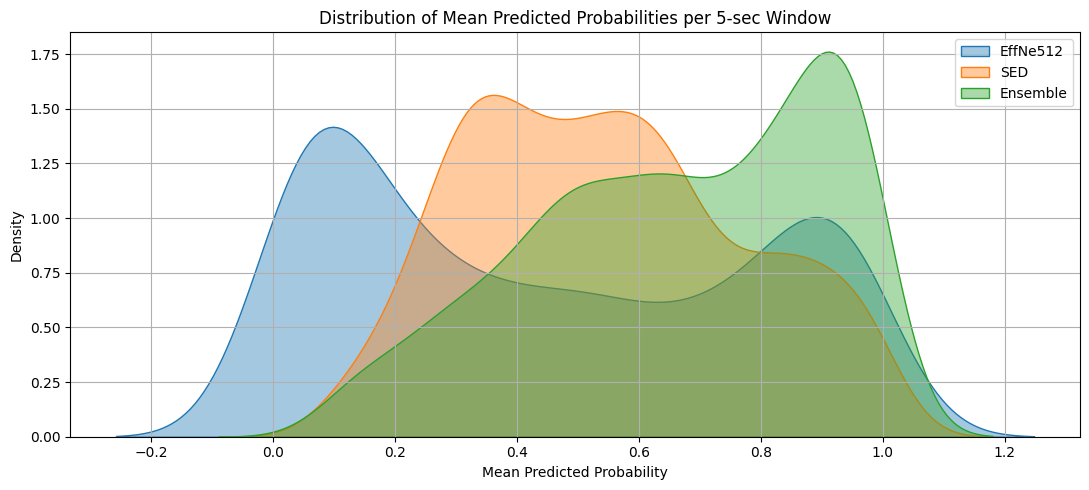

==== Summary Statistics per Model ====


,Model,Mean,Std,Min,Max
0,EffNe512,0.446164,0.334855,0.003075,0.987946
1,SED,0.544516,0.225930,0.096825,0.994038
2,Ensemble,0.665745,0.239699,0.096825,0.994038


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def visualize_model_prediction_distributions(inference_dfs, model_names=None):
    """
    複数モデルのinference出力を可視化する。row_idを除いて平均確率を使う。
    Args:
        inference_dfs (List[pd.DataFrame]): モデルごとの予測データフレーム（row_id含む）
        model_names (List[str], optional): モデル名リスト。未指定なら自動で"Model 1"などに。
    """
    if model_names is None:
        model_names = [f"Model {i+1}" for i in range(len(inference_dfs))]

    plt.figure(figsize=(11, 5))
    stats = []

    for df, name in zip(inference_dfs, model_names):
        # row_id を除いた予測部分だけ抽出
        preds_only = df.drop(columns=["row_id"])
        mean_probs = preds_only.max(axis=1)

        # 分布（KDEプロット）
        sns.kdeplot(mean_probs, label=name, fill=True, alpha=0.4)

        # 統計情報の記録
        stats.append({
            "Model": name,
            "Mean": mean_probs.mean(),
            "Std": mean_probs.std(),
            "Min": mean_probs.min(),
            "Max": mean_probs.max(),
        })

    plt.title("Distribution of Mean Predicted Probabilities per 5-sec Window")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 統計情報の表示
    stats_df = pd.DataFrame(stats)
    print("==== Summary Statistics per Model ====")
    display(stats_df)
    
from copy import deepcopy
dfs = deepcopy(inference_dfs)
dfs.append(ensemble_df)
visualize_model_prediction_distributions(dfs, model_names=["EffNe512", "SED", "Ensemble"])

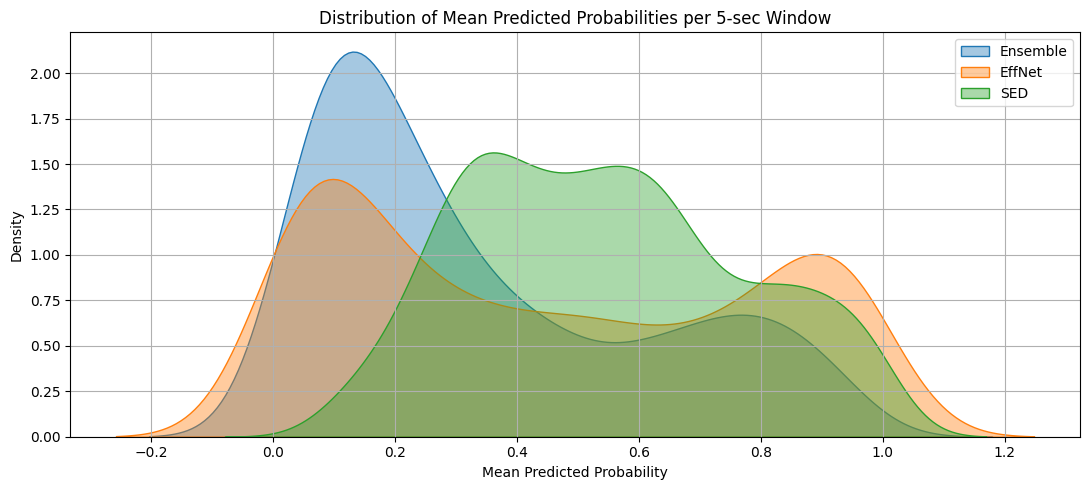

==== Summary Statistics per Model ====


,Model,Mean,Std,Min,Max
0,Ensemble,0.338132,0.271266,0.007852,0.968818
1,EffNet,0.446164,0.334855,0.003075,0.987946
2,SED,0.544516,0.225930,0.096825,0.994038


In [ ]:
visualize_model_prediction_distributions([ensemble_df, inference_dfs[0], inference_dfs[5]], model_names=["Ensemble", "EffNet", "SED"])

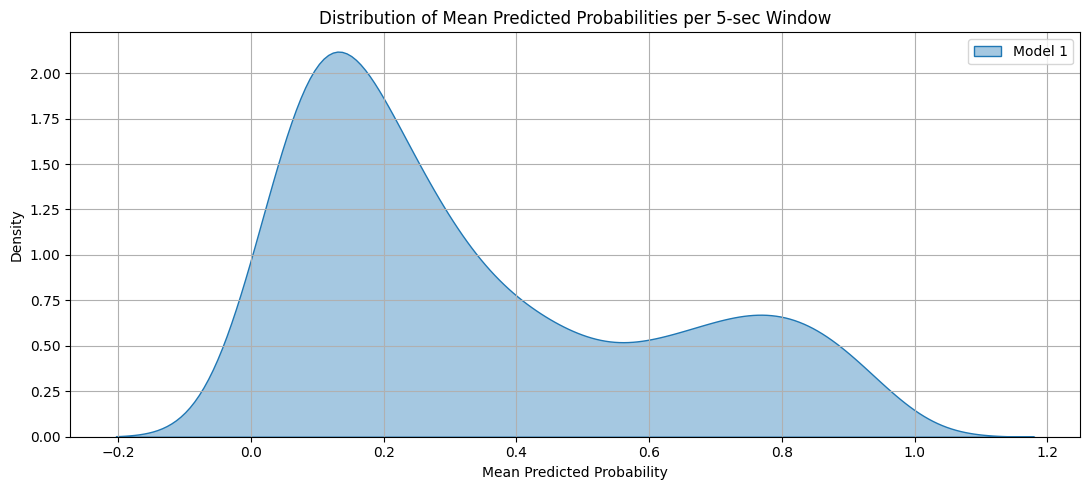

==== Summary Statistics per Model ====


,Model,Mean,Std,Min,Max
0,Model 1,0.338132,0.271266,0.007852,0.968818


In [ ]:
visualize_model_prediction_distributions([ensemble_df])

In [ ]:
def check_pred_stats(dfs, model_names=None):
    import pandas as pd

    stats = []
    for i, df in enumerate(dfs):
        name = model_names[i] if model_names else f"Model {i+1}"
        preds = df.drop(columns=["row_id"])
        stats.append({
            "Model": name,
            "Min": preds.min().min(),
            "Max": preds.max().max(),
            "Mean": preds.values.mean(),
            "Std": preds.values.std(),
            "Any < 0": (preds < 0).any().any(),
            "Any > 1": (preds > 1).any().any()
        })
    return pd.DataFrame(stats)

check_pred_stats(inference_dfs)

,Model,Min,Max,Mean,Std,Any < 0,Any > 1
0,Model 1,2.461697e-10,0.987946,0.003076,0.039361,False,False
1,Model 2,1.783248e-11,0.996925,0.003135,0.040065,False,False
2,Model 3,4.277787e-11,0.999312,0.002779,0.034774,False,False
3,Model 4,5.211413e-10,0.999170,0.003156,0.036844,False,False
4,Model 5,2.594609e-11,0.999000,0.002813,0.034097,False,False
5,Model 6,4.205318e-05,0.994038,0.021998,0.055670,False,False
